# Taxi-v3

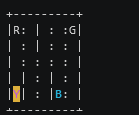

This task was introduced in to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

# Fixing dependencies in because of version imcompatabilities between tensorflow and gym. 

In [1]:
# !pip install keras
# !pip install keras-rl2
# !pip install cmake 'gym[atari]' scipy

## Importing Gym OpenAI

In [36]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

In [3]:
from keras import backend

In [36]:
import gym 
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt 
import numpy as np
# import keras.backend as K
tf.config.run_functions_eagerly(
    True
)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

### Here we implement the brute force/Random action sampling as baseline

In [78]:
env = gym.make('Taxi-v3')
states = env.observation_space.n
actions = env.action_space.n

#### No. of Actions Available are:

Left or right on a 1-D Axis, as in, where to move the cart in order to balance the pole.

In [7]:
actions

6

### We use this function to append the rendering so it doesn't produce long graphs and is easier to understand

In [14]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

### Baseline Implementation with random action sampling

In [15]:
episodes = 10
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


In [24]:

#brute force 
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
reward_baseline=0
reward_baseline_l=[]
done = False
episodes=100
while (episodes>0):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    reward_baseline+=reward
    reward_baseline_l.append(reward_baseline)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    episodes +=1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

KeyboardInterrupt: 

In [26]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 1298
State: 467
Action: 0
Reward: -1


KeyboardInterrupt: 

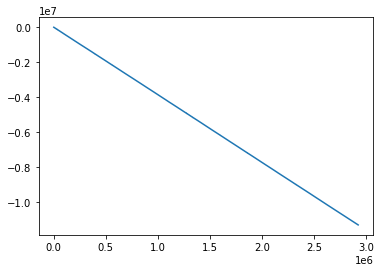

In [29]:
plt.plot(range(len(reward_baseline_l)), reward_baseline_l)

# Deep Q-Learning 

Uses neural networks to approximate Q-value functions. The state is given as input and Q-value of all possible. By maintaining the memory of the experiences, and an initial policy π.

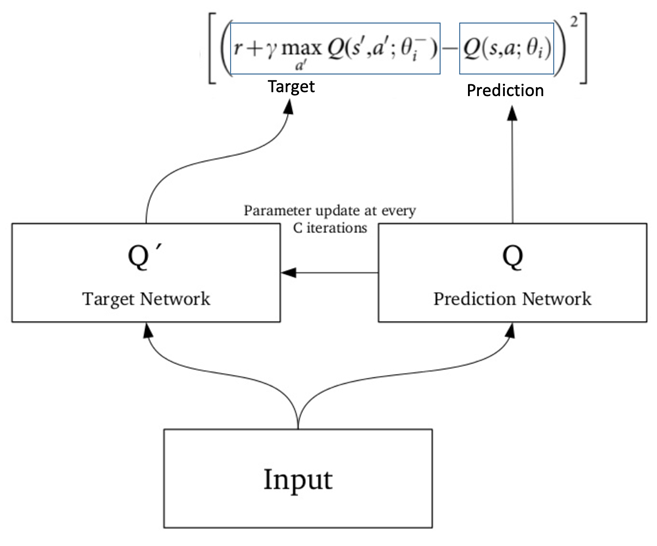


DQN leverages experience replay as a stabilization mechanism. Experience replay collects a buffer of historical transition models and randomly inserts the transition values during the Q-update function because we want to replicate the Temporal Difference target operation using our neural network rather than using a Q-table

### We Build our model here 

#### The first layer has to be flattened in the shape of (1,states)
#### While the last layer has to be of the shape of action.

In [30]:
def build_model(states, actions):
    model = Sequential()
    model.add(Embedding(states, 10, input_length=1))
    model.add(Reshape((10,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    print(model.summary())
    return model

In [31]:
model = build_model(states, actions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             5000      
                                                                 
 reshape (Reshape)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 50)                550       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 10,956
Trainable params: 10,956
Non-traina

### The summary of the model.

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             5000      
                                                                 
 reshape (Reshape)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 50)                550       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 10,956
Trainable params: 10,956
Non-traina

# Our Idea.

Our idea was the to implement Standard Error from Hessian Matrix, which has very often been used in Optimization problems outside of Reinforcement Learning. The problem is, the only way a derivative can be taken of y_pred w.r.t y_true is when there is decipherable function that **Gradient Tape** understands. 

$y_{pred}=f(y_{true})$

But there is no relation between $y_{pred}$ & $y_{true}$, however, the idea then was. 

$ys=model(env)$

But, this doesn't seem to work either. 
This is how we ended up on the idea.

In [33]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)
print(h)

Tensor("Reshape_2:0", shape=(5, 8, 5, 8), dtype=float32)


## or an easier way of writing the same

In [ ]:
x = tf.constant(4.0)

with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
#     z = tf.convert_to_tensor(tf.Variable(16.0), dtype=tf.float32)
#     print(z)
    z = tf.multiply(y,y)
#     print(z)
dz_dx = t.gradient(z,x)
print("The derivative is",dz_dx)

### However when there is not an existing function behind it

In [ ]:
x = tf.constant(4.0)

with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.convert_to_tensor(tf.Variable(16.0), dtype=tf.float32)
#     print(z)
#     z = tf.multiply(y,y)
#     print(z)
dz_dx = t.gradient(z,x)
print("The derivative is",dz_dx)

## This was the idea of our function of custom Standard Error from Hessian

In [ ]:
import tensorflow as tf
tf.__version__

### this was another idea to accomplish the same. Doesn't work however.

In [ ]:
@tf.function
def process_diag(tensor):
    tensor = tf.squeeze(tensor, axis=[-1])
    diag = tf.matrix_diag_part(tensor)
    zeros = tf.zeros(tf.shape(tensor)[0:-1], dtype=tf.float32)
    tensor = tf.expand_dims(tf.linalg.set_diag(tensor, zeros, name=None), -1)
    return tensor, diag 

@tf.function
def hessian(y_true, y_pred):
#     y_pred = tf.Variable(tf.convert_to_tensor(y_pred))
    y_pred = tf.Variable(y_pred)
    y_true = tf.Variable(tf.cast(y_true, y_pred.dtype))
    y_loss = tf.subtract(y_true-y_pred)
    
    with tf.GradientTape() as t2:
        t2.watch(y_pred)
        with tf.GradientTape() as t1:
            t1.watch(y_pred)
        g = t1.gradient(y_loss,y_pred)
        hessian = t2.jacobian(g, y_pred)
#         hessian, diag = process_diag(#solve? linalg.eig? (-(hessian)))
#         likelihood = backend.sqrt(diag)
    
    return hessian
            


# Until we landed on this function this idea.

We define $y_{pred} = f(y_{pred},y_{true})$ with $f$ being $y_{pred}-y_{true}$

In [ ]:
def hessian(y_true, y_pred):
    y_pred = tf.Variable(tf.convert_to_tensor(y_pred))
    y_true = tf.Variable(tf.cast(y_true, y_pred.dtype))
    with tf.GradientTape() as t2:
        t2.watch(y_true)
        with tf.GradientTape() as t1:
            t1.watch(y_true)
            #we use tf.subtract to construct our function
            y_loss = tf.subtract(y_pred, y_true)
            dy_dx = t1.gradient(y_loss, y_true)
        d2y_dx2 = t2.gradient(dy_dx, y_true)
        likelihood = backend.exp(dy_dx)
        loss = tf.reduce_sum(likelihood)
    return tf.convert_to_tensor(loss)

In [ ]:
y_true = tf.random.normal([7, 5])
y_pred = tf.multiply(y_true, y_true)
y_pred = tf.multiply(y_pred, y_true)

hessian(y_true, y_pred)

#### And we got the hessian "working"!


# Tensorflow's Autoderivative Models were our inspiration 

https://www.tensorflow.org/probability/examples/Generalized_Linear_Models

In [ ]:
import tensorflow_probability as tfp
import numpy as np
import scipy
from scipy import stats
def VerifyGradientAndFIM():
  model = tfp.glm.BernoulliNormalCDF()
  model_matrix = np.array([[1., 5, -2],
                           [8, -1, 8]])

  def _naive_grad_and_hessian_loss_fn(x, response):
    # Computes gradient and Hessian of negative log likelihood using autodiff.
    predicted_linear_response = tf.linalg.matvec(model_matrix, x)
    log_probs = model.log_prob(response, predicted_linear_response)
    grad_loss = tf.gradients(-log_probs, [x])[0]
    hessian_loss = tf.hessians(-log_probs, [x])[0]
    return [grad_loss, hessian_loss]

  def _grad_neg_log_likelihood_and_fim_fn(x, response):
    # Computes gradient of negative log likelihood and Fisher information matrix
    # using the formulas above.
    predicted_linear_response = tf.linalg.matvec(model_matrix, x)
    mean, variance, grad_mean = model(predicted_linear_response)

    v = (response - mean) * grad_mean / variance
    grad_log_likelihood = tf.linalg.matvec(model_matrix, v, adjoint_a=True)
    w = grad_mean**2 / variance

    fisher_info = tf.linalg.matmul(
        model_matrix,
        w[..., tf.newaxis] * model_matrix,
        adjoint_a=True)
    return [-grad_log_likelihood, fisher_info]

  @tf.function(autograph=False)
  def compute_grad_hessian_estimates():
    # Monte Carlo estimate of E[Hessian(-LogLikelihood)], where the expectation is
    # as written in "Claim (Fisher information)" above.
    num_trials = 20
    trial_outputs = []
    np.random.seed(10)
    model_coefficients_ = np.random.random(size=(model_matrix.shape[1],))
    model_coefficients = tf.convert_to_tensor(model_coefficients_)
    for _ in range(num_trials):
      # Sample from the distribution of `model`
      response = np.random.binomial(
          1,
          scipy.stats.norm().cdf(np.matmul(model_matrix, model_coefficients_))
      ).astype(np.float64)
      trial_outputs.append(
          list(_naive_grad_and_hessian_loss_fn(model_coefficients, response)) +
          list(
              _grad_neg_log_likelihood_and_fim_fn(model_coefficients, response))
      )

    naive_grads = tf.stack(
        list(naive_grad for [naive_grad, _, _, _] in trial_outputs), axis=0)
    fancy_grads = tf.stack(
        list(fancy_grad for [_, _, fancy_grad, _] in trial_outputs), axis=0)

    average_hess = tf.reduce_mean(tf.stack(
        list(hess for [_, hess, _, _] in trial_outputs), axis=0), axis=0)
    [_, _, _, fisher_info] = trial_outputs[0]
    return naive_grads, fancy_grads, average_hess, fisher_info

  naive_grads, fancy_grads, average_hess, fisher_info = [
      t.numpy() for t in compute_grad_hessian_estimates()]

  print("Coordinatewise relative error between naively computed gradients and"
        " formula-based gradients (should be zero):\n{}\n".format(
            (naive_grads - fancy_grads) / naive_grads))

  print("Coordinatewise relative error between average of naively computed"
        " Hessian and formula-based FIM (should approach zero as num_trials"
        " -> infinity):\n{}\n".format(
                (average_hess - fisher_info) / average_hess))

VerifyGradientAndFIM()


# Building the DQN Agent from keras.

In [37]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = EpsGreedyQPolicy()
    dqn = DQNAgent(model=model, nb_actions=actions, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
    return dqn

In [38]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1,nb_max_episode_steps=99, log_interval=100000)


Training for 1000000 steps ...
Interval 1 (0 steps performed)


C:\ProgramData\Anaconda3\envs\tfgym\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100000/100000 [==============================] - 315s 3ms/step - reward: -1.2955
1193 episodes - episode_reward: -108.472 [-936.000, 15.000] - loss: 3.677 - mae: 23.586 - mean_q: -22.972 - prob: 1.000

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 333s 3ms/step - reward: -0.0478
5921 episodes - episode_reward: -0.831 [-373.000, 15.000] - loss: 0.418 - mae: 7.850 - mean_q: 8.633 - prob: 1.000

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 339s 3ms/step - reward: 0.1396
6742 episodes - episode_reward: 2.072 [-67.000, 15.000] - loss: 0.003 - mae: 7.354 - mean_q: 12.675 - prob: 1.000

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 340s 3ms/step - reward: 0.1494
6759 episodes - episode_reward: 2.210 [-140.000, 15.000] - loss: 0.002 - mae: 7.346 - mean_q: 12.657 - prob: 1.000

Interval 5 (400000 steps performed)
100000/100000 [==============================] - 350s 4ms/step - r

In [27]:
scores = dqn.test(env, nb_episodes=150, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 150 episodes ...
Episode 1: reward: 6.000, steps: 15
Episode 2: reward: 4.000, steps: 17
Episode 3: reward: 15.000, steps: 6
Episode 4: reward: 3.000, steps: 18
Episode 5: reward: 6.000, steps: 15
Episode 6: reward: 6.000, steps: 15
Episode 7: reward: 7.000, steps: 14
Episode 8: reward: 8.000, steps: 13
Episode 9: reward: 8.000, steps: 13
Episode 10: reward: 5.000, steps: 16
Episode 11: reward: 4.000, steps: 17
Episode 12: reward: 11.000, steps: 10
Episode 13: reward: 6.000, steps: 15
Episode 14: reward: 9.000, steps: 12
Episode 15: reward: 6.000, steps: 15
Episode 16: reward: 14.000, steps: 7
Episode 17: reward: 9.000, steps: 12
Episode 18: reward: 10.000, steps: 11
Episode 19: reward: 8.000, steps: 13
Episode 20: reward: 7.000, steps: 14
Episode 21: reward: 7.000, steps: 14
Episode 22: reward: 11.000, steps: 10
Episode 23: reward: 9.000, steps: 12
Episode 24: reward: 7.000, steps: 14
Episode 25: reward: 6.000, steps: 15
Episode 26: reward: 3.000, steps: 18
Episode 27: rew

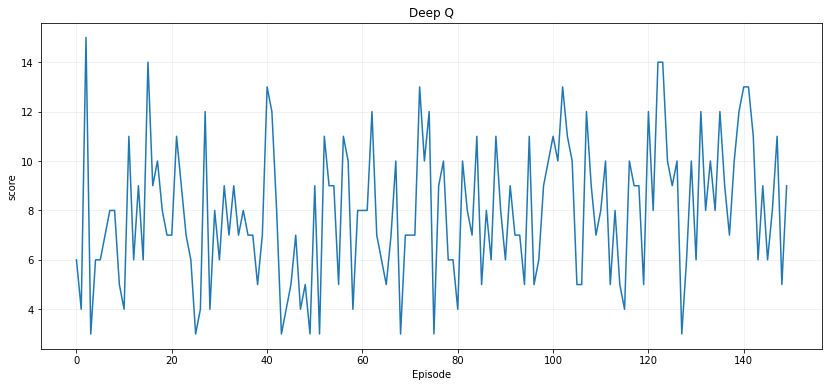

In [28]:
fig = plt.figure(figsize=(14,6))
plt.plot(scores.history['episode_reward'])
plt.ylabel('score')
plt.xlabel('Episode')
plt.title('Deep Q')
plt.grid(alpha=0.2)

In [29]:
test_score = dqn.test(env, nb_episodes=1000, visualize=False)

Testing for 1000 episodes ...
Episode 1: reward: 7.000, steps: 14
Episode 2: reward: 12.000, steps: 9
Episode 3: reward: 5.000, steps: 16
Episode 4: reward: 9.000, steps: 12
Episode 5: reward: 9.000, steps: 12
Episode 6: reward: 10.000, steps: 11
Episode 7: reward: 6.000, steps: 15
Episode 8: reward: 10.000, steps: 11
Episode 9: reward: 6.000, steps: 15
Episode 10: reward: 11.000, steps: 10
Episode 11: reward: 8.000, steps: 13
Episode 12: reward: 4.000, steps: 17
Episode 13: reward: 8.000, steps: 13
Episode 14: reward: 7.000, steps: 14
Episode 15: reward: 12.000, steps: 9
Episode 16: reward: 10.000, steps: 11
Episode 17: reward: 5.000, steps: 16
Episode 18: reward: 8.000, steps: 13
Episode 19: reward: 7.000, steps: 14
Episode 20: reward: 9.000, steps: 12
Episode 21: reward: 7.000, steps: 14
Episode 22: reward: 10.000, steps: 11
Episode 23: reward: 12.000, steps: 9
Episode 24: reward: 8.000, steps: 13
Episode 25: reward: 7.000, steps: 14
Episode 26: reward: 11.000, steps: 10
Episode 27:

# Q learning


**Q-learning** is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.   

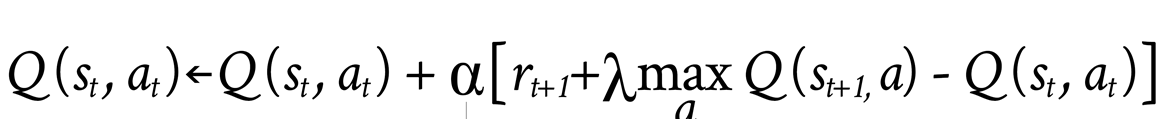

For any finite Markov decision process (FMDP), Q-learning finds an optimal policy in the sense of maximizing the expected value of the total reward over any and all successive steps, starting from the current state.

Q-learning can identify an optimal action-selection policy for any given FMDP, given infinite exploration time and a partly-random policy. "Q" refers to the function that the algorithm computes – the expected rewards for an action taken in a given state.

In [42]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [43]:
%%time

import random
alpha = 0.1
gamma = 0.6
epsilon = 0.1
reward_Q=[]
rewardQ=0
def train_agent(env, alpha=0.1, gamma=0.6, epsilon=0.1):
  # Hyperparameters
  # For plotting metrics
  all_epochs = []
  all_penalties = []
  reward_Q=[]
  rewardQ=0
  frames=[]
  for i in range(1, 100001):
      state = env.reset()

      epochs, penalties, reward, = 0, 0, 0
      done = False
      
      while not done:
          if random.uniform(0, 1) < epsilon:
              action = env.action_space.sample() # Explore action space
          else:
              action = np.argmax(q_table[state]) # Exploit learned values

          next_state, reward, done, info = env.step(action) 
          rewardQ+=reward
          reward_Q.append(rewardQ)
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
          )
            
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
        
          epochs += 1
          
      if i % 100 == 0:
          clear_output(wait=True)
          print(f"Episode: {i}")

  print("Training finished.\n")
  return reward_Q, frames

Wall time: 0 ns


In [44]:
reward, frames=train_agent(env)

Episode: 100000
Training finished.



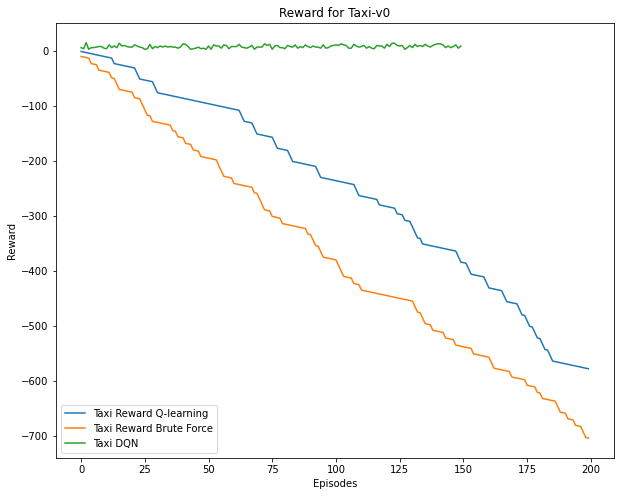

In [30]:
plt.figure(figsize=(10,8))
plt.plot(reward[0:200], label="Taxi Reward Q-learning")
plt.plot(reward_baseline_l[0:200], label="Taxi Reward Brute Force")
plt.plot(scores.history['episode_reward'], label="Taxi DQN")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward for Taxi-v0")
plt.legend()

# Finally if you'd like to reload them model from memory

In [ ]:
dqn.save_weights('dqn_weights_taxi.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('Taxi-v3')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights_taxi.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
#!pip install imageio
!pip install imageio-ffmpeg

In [ ]:
import imageio

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = env.reset()
      video.append_data(env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        video.append_data(env.render())
  return embed_mp4(filename)

create_policy_eval_video(dqn.policy, "trained-agent")

# Automatic Curriculum Learning For Taxi v3


# Automatic Curriculum Learning 

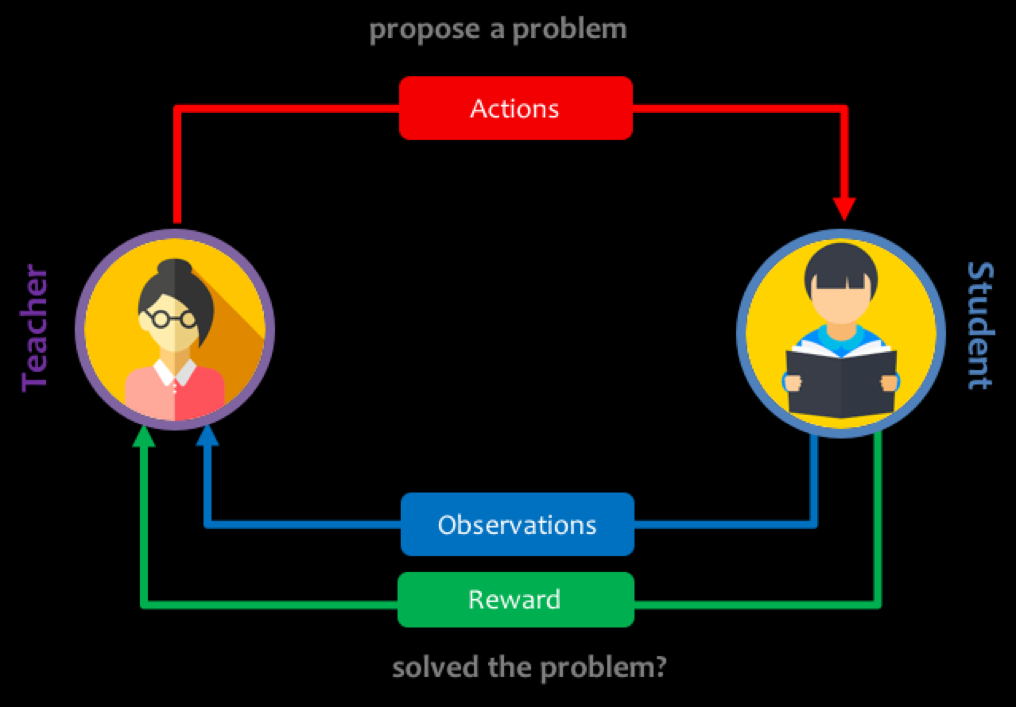

1. Student network: receives a task, and is expected to interact in the environment and learn how to solve it.

2. Teacher network: proposes tasks by observing the progress signal of the student and sampling new tasks that maximise this signal.

### **STUDENT**

The student can be any classical Deep Reinforcement Learning agent, as from its point of view, it is only expected to solve tasks provided to it. It will be trained end-to-end, using the extrinsic reward function of the task being tackled.

### **TEACHER**

The teacher should be able to follow the student progress, and propose tasks in a sequence which overall should lead to the student solving complex tasks it couldn’t before. It effectively needs to explore the space of tasks effectively, as depending on the expertise of the student the same task can be valuable or useless.

In [48]:
!pip install pygame

In [111]:
import numpy as np
import time
import random
import matplotlib as plt
import gym
import pygame
import os
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

## Make the environment here

Set the random seed for reproducibility

In [109]:


STUDENT_LR = 0.0005
TEACHER_LR = 0.001
TEACHER_PRECISION = 0.99
IMPROVEMENT_WEIGHT = 0.001
RANDOM_SEED = 6
TOTAL_EPISODES = 1000
TEACHER_OUTPUT_SIZE = 1
WIN_REWARD = 9.5

tf.config.run_functions_eagerly(True)

env = gym.make('Taxi-v3')
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



@tf.function
def one_hot_encoder(index, size):
    return tf.one_hot(indices=index, depth=size).numpy()


def make_student(state_shape, output_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=state_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=TEACHER_LR), metrics=['accuracy'])
    return model

def make_teacher(state_shape, output_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=state_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(action_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=STUDENT_LR), metrics=['accuracy'])
    return model

def CL_teacher(observation, nextObservation, teacherAgent, reward, done):
#     obsvReshape = observation.reshape([1, observation.shape[0]])
#     nextObsvReshape = nextObservation.reshape([1, nextObservation.shape[0]])
    
    currActionQuality = np.array(teacherAgent.predict(np.array(observation).reshape(-1,1)))
    nextActionQuality = np.array(teacherAgent.predict(np.array(observation).reshape(-1,1)))
    
    targetQuality = reward + (1-done)*TEACHER_PRECISION*nextActionQuality
    improvement = targetQuality-currActionQuality
    teacherAgent.fit(observation, np.vstack([targetQuality]), verbose=0)
    return improvement

@tf.function
def student_action(observation, studentAgent, env):
    probAction = studentAgent.predict(np.array(observation).reshape(-1,1))
    action = np.random.choice(env.action_space.n, 1, p=probAction)[0]
    oneHotAction = tf.one_hot(indices=action, depth=env.action_space.n).numpy()
    return action, probAction, oneHotAction
    
    
# def main():
states = env.observation_space.n
actions = env.action_space.n

studentAgent = make_student(states, actions)
teacherAgent = make_teacher(states, actions)

cumEpisodeRewards = deque(maxlen=100)

for episode in range(TOTAL_EPISODES):
    episodeReward = 0
    observation = env.reset()
    done = False

    while not done:

        env.render()

        action, probAction, oneHotAction = student_action(observation, studentAgent, env)

        nextObservation, reward, done, _ = env.step(action)

        improvement = CL_teacher(observation, nextObservation, teacherAgent, reward, done)

        studentTarget = probAction + IMPROVEMENT_WEIGHT * (oneHotAction-probAction) * improvement

        studentAgent.fit(observation, np.vstack([studentTarget]), verbose=0)

        observation = nextObservation
        episodeReward += reward
        
    if done:
                print(f'Episode Reward={episodeReward} at episode {episode}')
                cumEpisodeRewards.append(episodeReward)
                mean_score = np.mean(cumEpisodeRewards)

                if mean_score >= WIN_REWARD and episode >= 100:
                    print(f'Total episodes: {episode} \n Solved after {episode-100} episodes!')

env.close()
                
# if __name__ == '__main__':
#     main()  

TypeError: 'int' object is not iterable